In [1]:
%load_ext autoreload
%autoreload 2

import fastai
from fastai import *
from fastai.vision import *

In [2]:
fastai.__version__

'1.0.58.dev0'

In [3]:
lesson_dir_path = Path('lesson2-download')
images_dir_path = lesson_dir_path/'images'

### Download stuff from google - note that quality is pretty bad, so we'll do filtering later

In [4]:
classes = ('model_s', 'model_x', 'model_3', 'model_y')

In [5]:
def _download_class_images(c):    
    c_dir_path = images_dir_path/c
    if c_dir_path.exists():
        shutil.rmtree(c_dir_path)
    c_dir_path.mkdir(parents=True, exist_ok=True)
    download_images(images_dir_path/(c + '.csv'), c_dir_path) # I already gathered csv from google search

In [6]:
for c in classes:
    _download_class_images(c)

In [7]:
def _verify_class_images(c):
    c_dir_path = images_dir_path/c
    verify_images(c_dir_path)

In [8]:
for c in classes: 
    _verify_class_images(c)

### Get data bunch

In [9]:
tfms = get_transforms()

In [67]:
src = (ImageList.from_folder(path=images_dir_path)
                .split_by_rand_pct(0.2, seed=1)
                .label_from_folder())

# Resnet34

### Do initial size of 112

In [11]:
data = (src.transform(tfms, size=112)
           .databunch()
           .normalize(imagenet_stats))

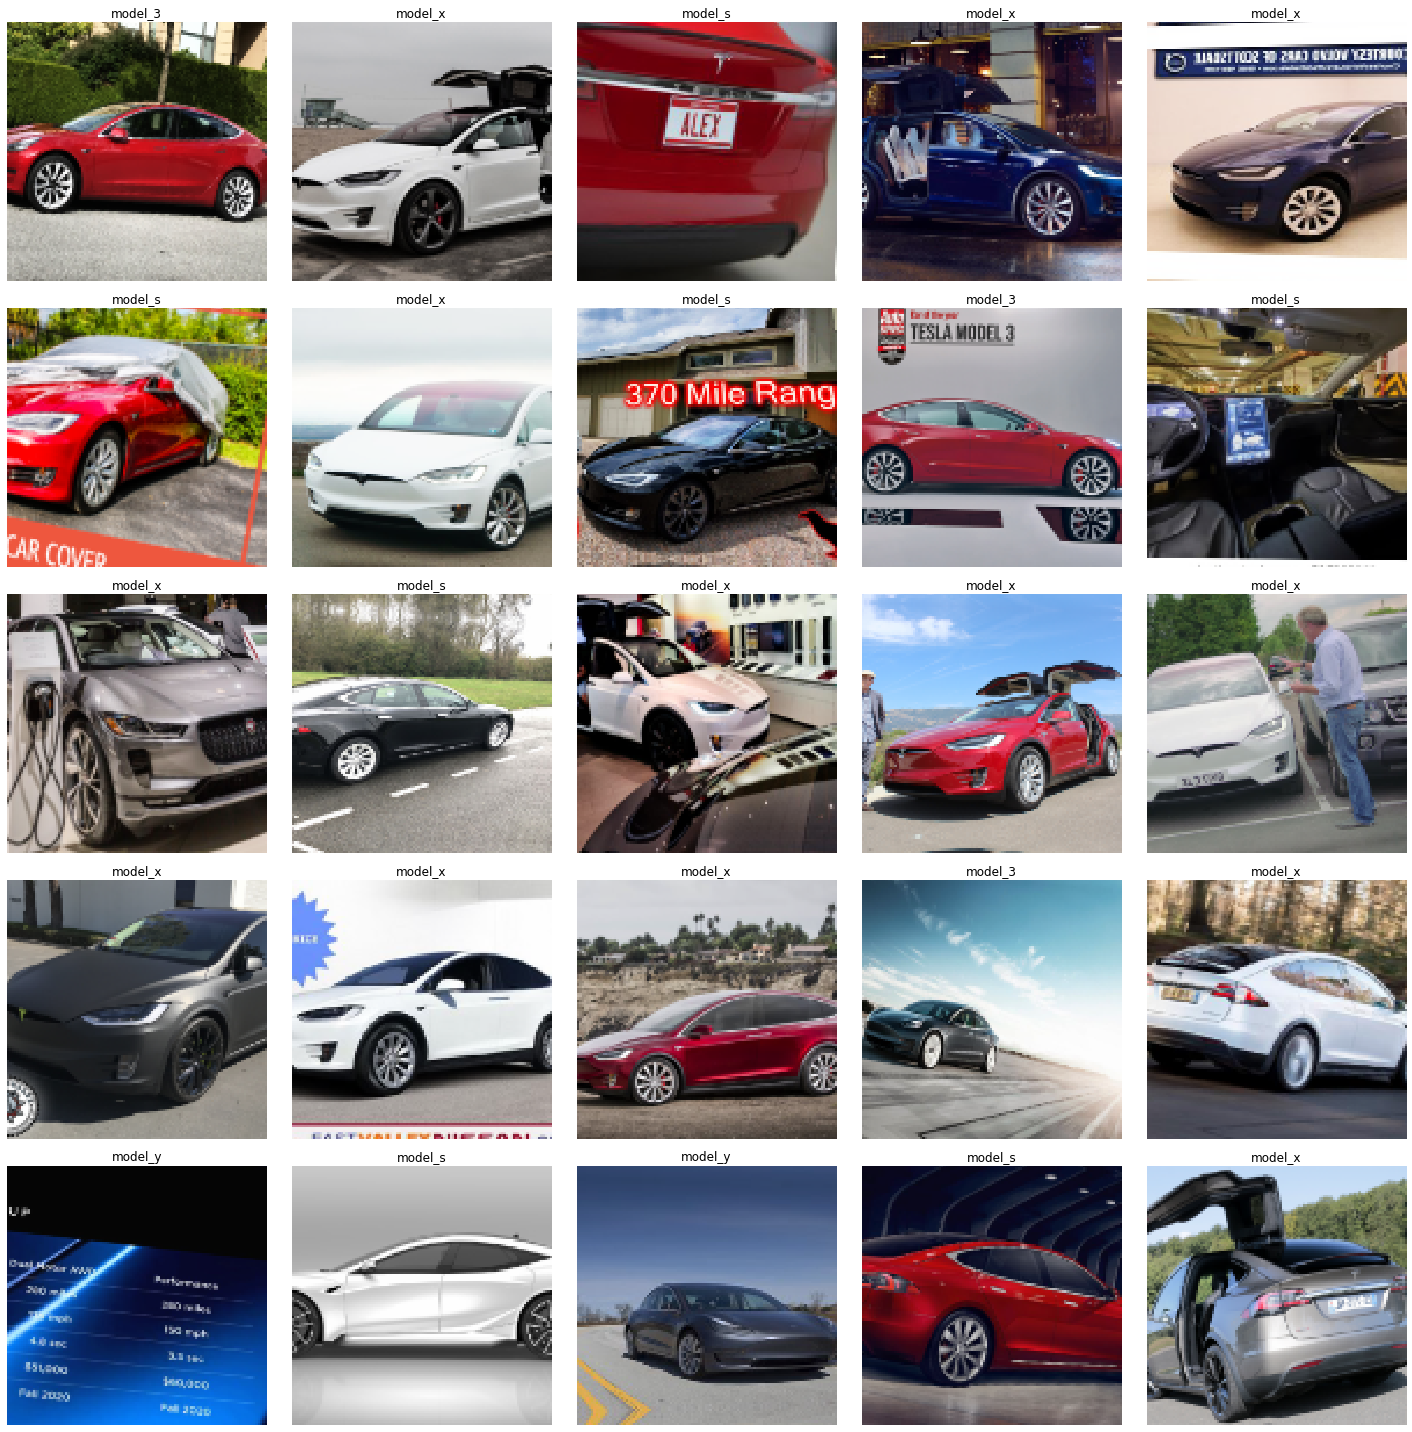

In [12]:
data.show_batch()

In [13]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


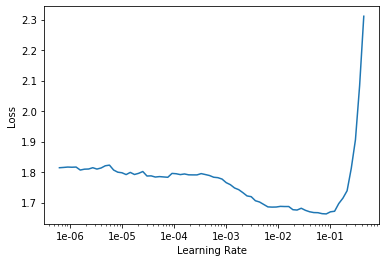

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
lr = 1e-2
learn.fit_one_cycle(10, slice(lr))

In [16]:
learn.save('resnet34-base-size_112-stage_1')

In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


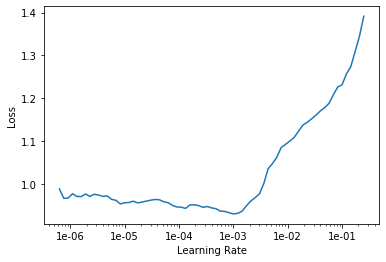

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, slice(1e-6, lr/10))

In [20]:
learn.save('resnet34-base-size_112-stage_2')

## Do size of 224

In [21]:
data = (src.transform(tfms, size=224)
           .databunch()
           .normalize(imagenet_stats))

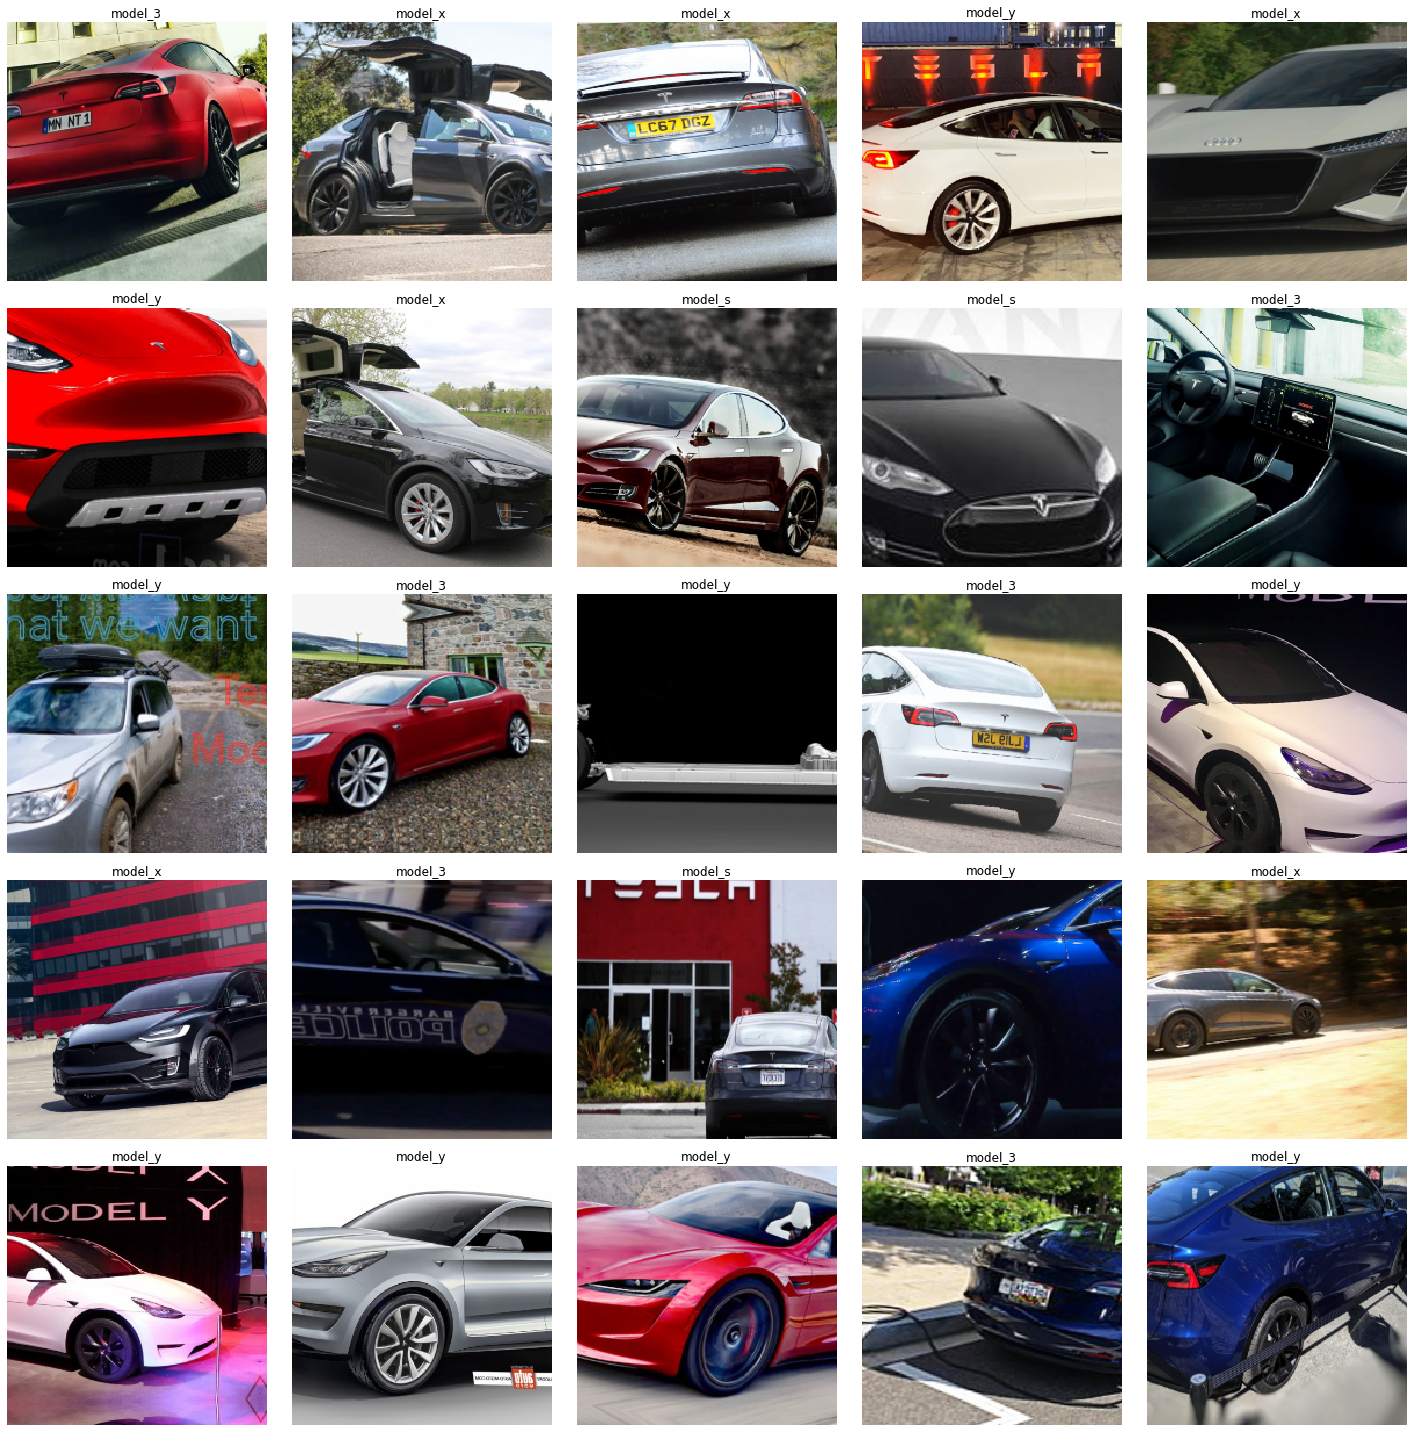

In [22]:
data.show_batch()

In [23]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.load('resnet34-base-size_112-stage_2')

Learner(data=ImageDataBunch;

Train: LabelList (1460 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
model_x,model_x,model_x,model_x,model_x
Path: /home/blaberj/fastai_course/lesson2-download/images;

Valid: LabelList (364 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
model_x,model_s,model_x,model_3,model_x
Path: /home/blaberj/fastai_course/lesson2-download/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


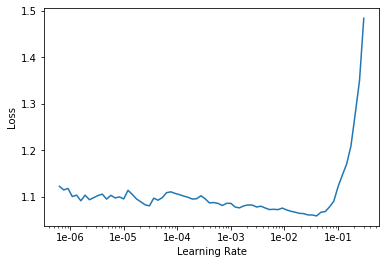

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

In [26]:
learn.save('resnet34-base-size_224-stage_1')

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


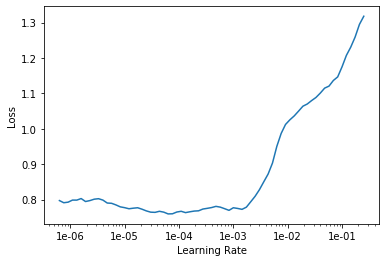

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(5, slice(1e-6, lr/10))

In [30]:
learn.save('resnet34-base-size_224-stage_2')

In [31]:
learn.export('resnet34-base-size_224.pkl')

# Clean up data

In [36]:
from fastai.widgets import *

In [37]:
# Must create databunch without split, since DatasetFormatter only acts on training set
data = (ImageList.from_folder(path=images_dir_path)
                 .split_none()
                 .label_from_folder()
                 .transform(tfms, size=224)
                 .databunch()
                 .normalize(imagenet_stats))

In [48]:
learn = load_learner(images_dir_path, 'resnet34-base-size_224.pkl')
learn.load('resnet34-base-size_224-stage_2')
learn.data = data

In [39]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [40]:
ImageCleaner(ds, idxs, images_dir_path)

'No images to show :)'

### Note to self: do a better job getting data; so many are bad/mislabeled... Also note I tried to remove duplicates... from_similars didn't work for some reason but I think it's ok

# Re-run with cleaned data; note that since I used a seed to split the validation set originally, things will get jumbled up if I split with a seed again, so I'm just gonna re-train from scratch (i.e. some of the validation set might leak into the training set if I finetune with original model)

In [50]:
src = (ImageList.from_csv(images_dir_path, 'cleaned.csv')
                .split_by_rand_pct(0.2, seed=1)
                .label_from_df())

In [51]:
data = (src.transform(tfms, size=112)
           .databunch()
           .normalize(imagenet_stats))

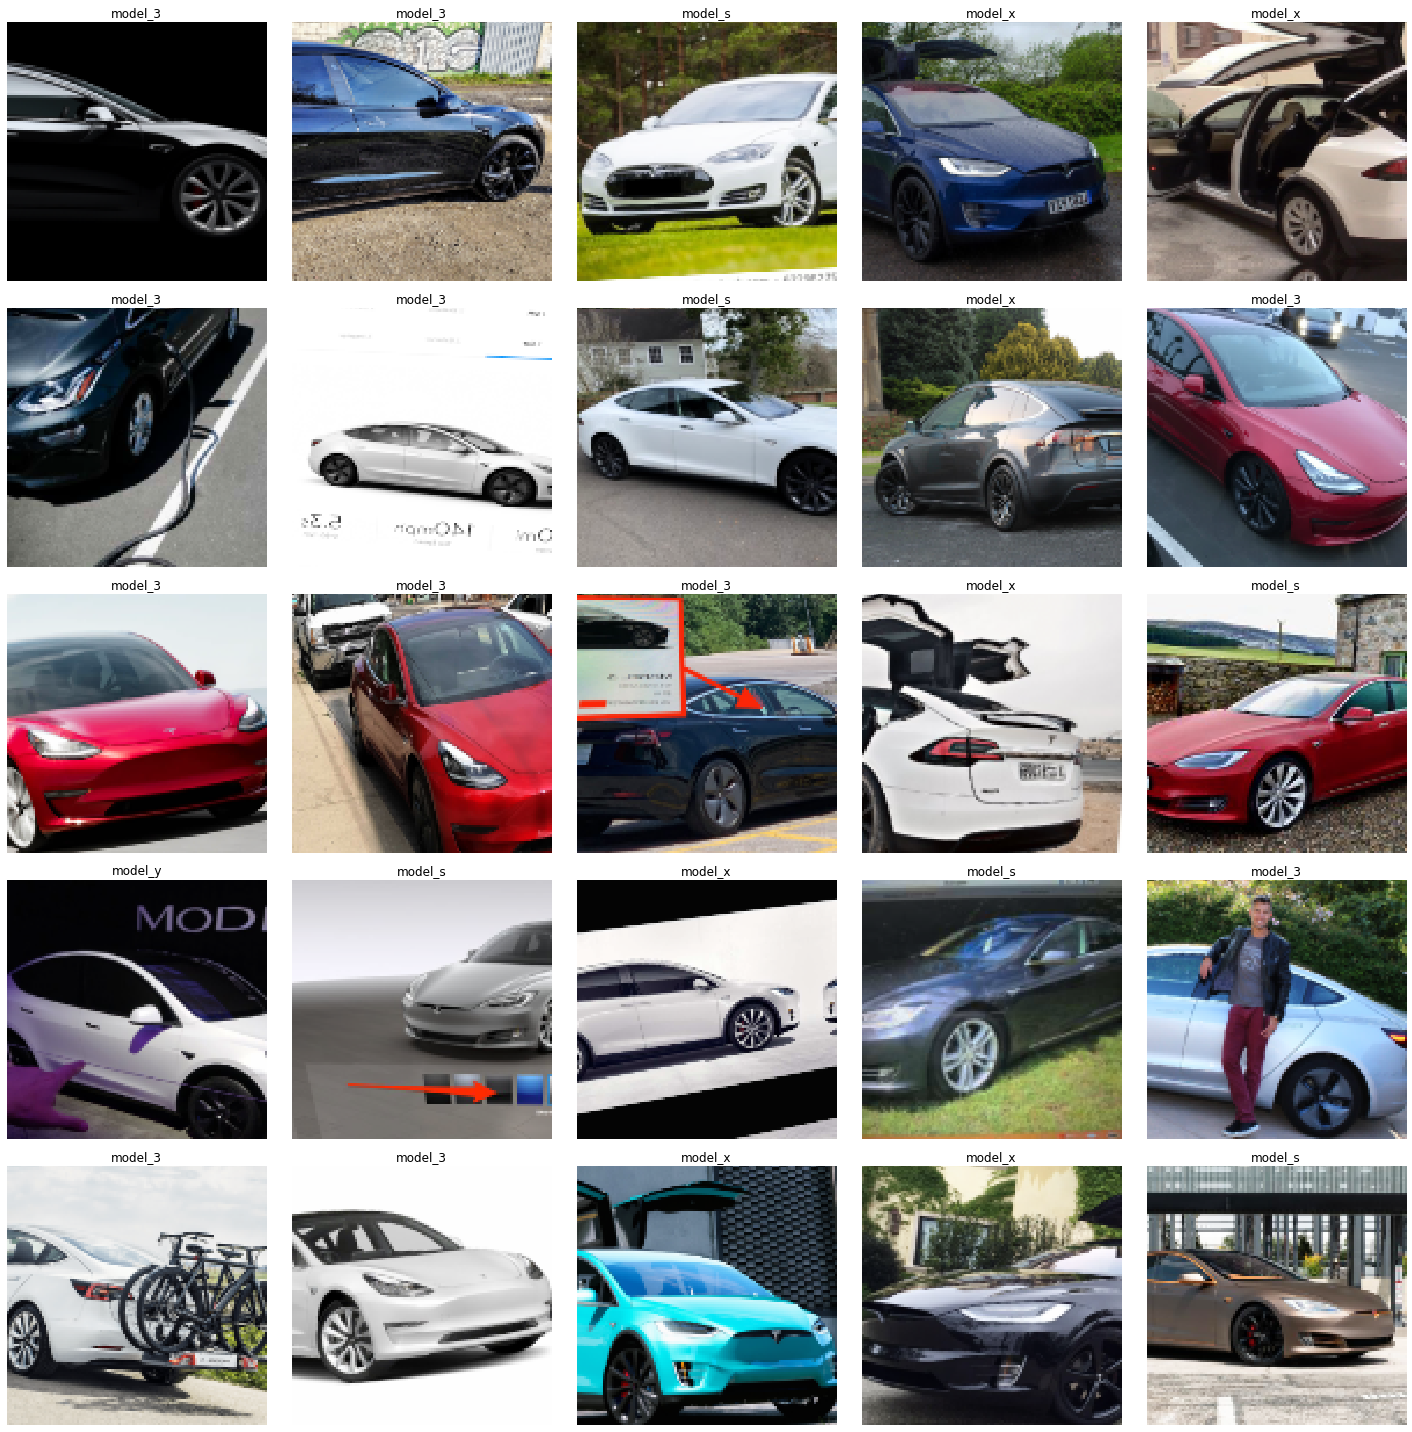

In [52]:
data.show_batch()

In [53]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
lr = 1e-2
learn.fit_one_cycle(10, slice(lr))
learn.save('resnet34-cleaned-size_112-stage_1')

In [54]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, lr/10))
learn.save('resnet34-cleaned-size_112-stage_2')

In [55]:
data = (src.transform(tfms, size=224)
           .databunch()
           .normalize(imagenet_stats))

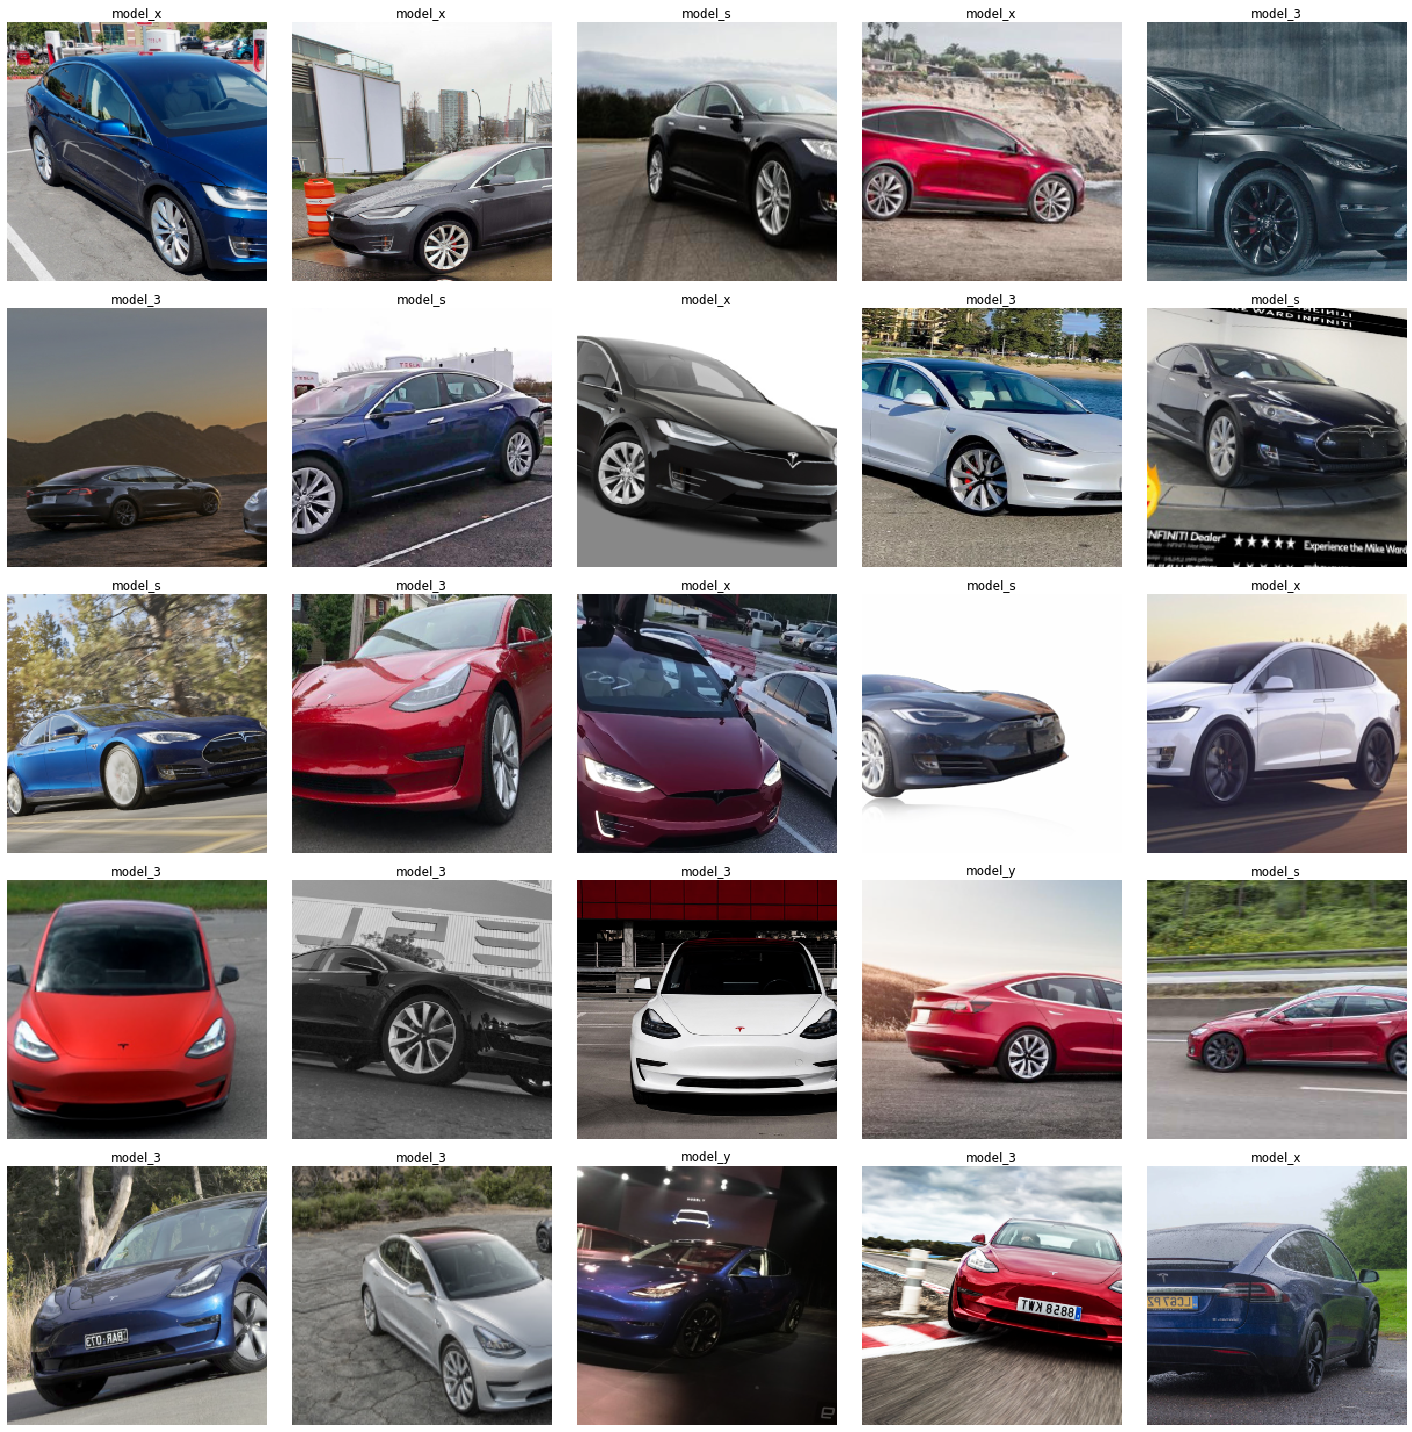

In [56]:
data.show_batch()

In [57]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.load('resnet34-cleaned-size_112-stage_2')
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))
learn.save('resnet34-cleaned-size_224-stage_1')

In [58]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, lr/10))
learn.save('resnet34-cleaned-size_224-stage_2')

In [59]:
learn.export('resnet34-cleaned-size_224.pkl')

## 0.585165 => 0.713755 accuracy after cleaning. I'm sure cleaning more and adding more data would improve the model quite a bit

In [60]:
learn = load_learner(images_dir_path, 'resnet34-cleaned-size_224.pkl')
learn.load('resnet34-cleaned-size_224-stage_2')
learn.data = data  # Do this so same validation set is used

In [61]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

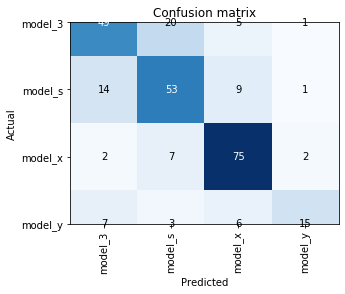

In [62]:
interp.plot_confusion_matrix()

In [63]:
interp.most_confused(min_val=5)

[('model_3', 'model_s', 20),
 ('model_s', 'model_3', 14),
 ('model_s', 'model_x', 9),
 ('model_x', 'model_s', 7),
 ('model_y', 'model_3', 7),
 ('model_y', 'model_x', 6),
 ('model_3', 'model_x', 5)]